## Random Forest

Random Forest est un algorithme d'ensemble basé sur la méthode des arbres de décision. Il construit plusieurs arbres de décision indépendants sur des sous-échantillons bootstrap du jeu de données d'entraînement, puis agrège leurs prédictions par vote majoritaire pour la classification. Chaque arbre est entraîné sur un sous-ensemble aléatoire des features pour introduire de la diversité.

**Formule de prédiction pour la classification :**
\[
\hat{y} = \arg\max_k \sum_{i=1}^T I(\hat{y}_i^{(t)} = k)
\]
où \( T \) est le nombre d'arbres, \( \hat{y}_i^{(t)} \) est la prédiction du \( t \)-ième arbre pour la classe \( k \), et \( I \) est la fonction indicatrice.

**Critère de division (Gini) :**
\[
Gini = 1 - \sum_{k=1}^K p_k^2
\]
où \( p_k \) est la proportion d'échantillons de classe \( k \) dans le nœud.

**Réduction de variance :**
\[
Var(\hat{y}) = \frac{1}{T} Var(\hat{y}^{(t)}) + \frac{T-1}{T} Cov(\hat{y}^{(t)}, \hat{y}^{(t')})
\]
L'agrégation réduit la variance tout en maintenant un faible biais.

In [1]:
import os
import sys
import subprocess


def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Liste des packages requis
required_packages = [
    'numpy', 
    'pandas', 
    'matplotlib', 
    'seaborn', 
    'scikit-learn',
    'scipy',
    'xgboost',
    'lightgbm',
    'torch',
    'gdown',
    'joblib'
]

for package in required_packages:
    try:
        if package == 'scikit-learn':
            __import__('sklearn')
        elif package == 'torch':
            __import__('torch')
        else:
            __import__(package)
    except ImportError:
        print(f"Installation de {package}...")
        install_package(package)

# Imports standards
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Scipy
from scipy.stats import chi2_contingency, ttest_ind

# Scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, precision_score, recall_score,
    precision_recall_curve, average_precision_score, PrecisionRecallDisplay,
    roc_curve, roc_auc_score, RocCurveDisplay
)

# Modèles de boosting
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Pandas plotting
from pandas.plotting import scatter_matrix

%matplotlib inline


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/amauryjanin/Library/Mobile Documents/com~apple~CloudDocs/Documents/IMT atlantique/TAF 2A/IA UE D/Projet AAA/.venv/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/amauryjanin/Library/Mobile Documents/com~apple~CloudDocs/Documents/IMT atlantique/TAF 2A/IA UE D/Projet AAA/.venv/lib/python3.11/site-packages/traitlets/config/application.py"

In [2]:

# Obtenir le chemin du notebook
notebook_path = os.path.abspath('')
print(f"Répertoire actuel : {notebook_path}")

# Se placer dans le répertoire du notebook
os.chdir(notebook_path)
DATA_PATH = os.path.join(os.getcwd(),'loan_data.csv')
if not os.path.exists(DATA_PATH):
    import gdown
    # ID du fichier Google Drive (extrait du lien)
    file_id = '1aSRxZA8X0eRZAYoKwxuLLL98pBkmwc0Q'
    url = f'https://drive.google.com/uc?id={file_id}'
    
    # Télécharger le fichier
    gdown.download(url, DATA_PATH, quiet=False)
    
       
    
df = pd.read_csv(DATA_PATH)
print('Dimensions:', df.shape)
df.head()

Répertoire actuel : /Users/amauryjanin/Library/Mobile Documents/com~apple~CloudDocs/Documents/IMT atlantique/TAF 2A/IA UE D/Projet AAA
Dimensions: (45000, 14)


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [3]:
# Aperçu rapide et types
display(df.info())
print('\nValeurs manquantes par colonne:\n', df.isnull().sum())
# convertir person_age si présent
if 'person_age' in df.columns:
    df['person_age'] = df['person_age'].astype(int)

# Détection simple des colonnes catégorielles vs numériques (basée sur dtype)
cat_cols = [c for c in df.columns if df[c].dtype == 'object']
num_cols = [c for c in df.columns if c not in cat_cols]
print('Colonnes catégorielles:', cat_cols)
print('Colonnes numériques:', num_cols)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

None


Valeurs manquantes par colonne:
 person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64
Colonnes catégorielles: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']
Colonnes numériques: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'loan_status']


In [4]:
# Rééquilibrage de la target `loan_status` à ~50/50 via undersampling (suppression d'exemples des classes majoritaires)

print('Distribution avant (counts):')
print(df['loan_status'].value_counts(dropna=False))

counts = df['loan_status'].value_counts()
min_n = counts.min()
parts = []
for cls, n in counts.items():
    subset = df[df['loan_status'] == cls]
    if n > min_n:
        # Sous-échantillonnage de la classe majoritaire jusqu'à min_n (sans remplacement)
        subset = subset.sample(n=min_n, replace=False, random_state=42)
    parts.append(subset)
df = pd.concat(parts, axis=0).sample(frac=1, random_state=42).reset_index(drop=True)
print('Distribution après (équilibrée):')
print(df['loan_status'].value_counts())


Distribution avant (counts):
loan_status
0    35000
1    10000
Name: count, dtype: int64
Distribution après (équilibrée):
loan_status
1    10000
0    10000
Name: count, dtype: int64


In [5]:
# Prétraitement général: imputation/scale/OHE via ColumnTransformer
# construire X et y en incluant les colonnes clean
cols_keep = [c for c in df.columns if c != 'loan_status']
X = df[cols_keep].copy()
y = df['loan_status'].copy()


# Séparation des données numériques et catégorielles
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]
print('num_cols:', num_cols)
print('cat_cols:', cat_cols)

numeric_transformer = Pipeline([('scaler', StandardScaler())])
categorical_transformer = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer([('num', numeric_transformer, num_cols), ('cat', categorical_transformer, cat_cols)])

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train/Test shapes:', X_train.shape, X_test.shape)

num_cols: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']
cat_cols: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']
Train/Test shapes: (16000, 13) (4000, 13)


In [6]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Pipeline avec AdaBoost
pipe_ada = Pipeline([
    ('preprocessor', preprocessor), 
    ('clf', AdaBoostClassifier(random_state=42, algorithm='SAMME'))
])

# GridSearch pour AdaBoost
param_grid_ada = {
    'clf__n_estimators': [300, 500, 700],
    'clf__learning_rate': [0.5, 1.0, 1.5, 2],
    'clf__estimator': [
        DecisionTreeClassifier(max_depth=1),
        DecisionTreeClassifier(max_depth=2),
        DecisionTreeClassifier(max_depth=3)
    ]
}

gs_ada = GridSearchCV(pipe_ada, param_grid_ada, cv=5, scoring='f1', n_jobs=-1, verbose=1)
gs_ada.fit(X_train, y_train)

print('Best params:', gs_ada.best_params_)
best_ada = gs_ada.best_estimator_

# Évaluation
y_pred_ada = best_ada.predict(X_test)
y_proba_ada = best_ada.predict_proba(X_test)[:, 1]

print(f'Test accuracy: {accuracy_score(y_test, y_pred_ada):.4f}')
print(f'Test F1-score: {f1_score(y_test, y_pred_ada):.4f}')
print('\nClassification report:\n', classification_report(y_test, y_pred_ada))

Fitting 5 folds for each of 36 candidates, totalling 180 fits



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/amauryjanin/Library/Mobile Documents/com~apple~CloudDocs/Documents/IMT atlantique/TAF 2A/IA UE D/Projet AAA/.venv/lib/python3.11/site-packages/joblib/externals/loky/backend/popen_loky_posix.py", line 180, in <module>
    exitcode = process_obj._bootstrap()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/

Best params: {'clf__estimator': DecisionTreeClassifier(max_depth=3), 'clf__learning_rate': 1.5, 'clf__n_estimators': 700}
Test accuracy: 0.8982
Test F1-score: 0.8987

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.90      2000
           1       0.89      0.90      0.90      2000

    accuracy                           0.90      4000
   macro avg       0.90      0.90      0.90      4000
weighted avg       0.90      0.90      0.90      4000



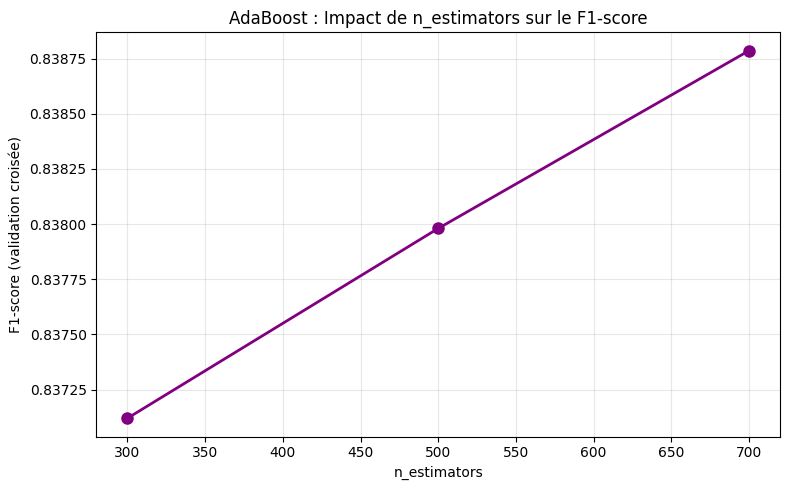


AdaBoost - F1-score moyen par n_estimators :
  • n_estimators=300: F1=0.8371
  • n_estimators=500: F1=0.8380
  • n_estimators=700: F1=0.8388


In [7]:
# Analyser l'impact de n_estimators sur AdaBoost
cv_results_ada = pd.DataFrame(gs_ada.cv_results_)

# Extraire les valeurs uniques
n_ests_ada = sorted(cv_results_ada['param_clf__n_estimators'].unique())
learning_rates_ada = sorted(cv_results_ada['param_clf__learning_rate'].unique())

# Calculer la moyenne du F1-score pour chaque n_estimators (moyenne sur les autres hyperparamètres)
means_n_ada = []
for n_est in n_ests_ada:
    mask = cv_results_ada['param_clf__n_estimators'] == n_est
    data = cv_results_ada[mask]['mean_test_score'].values
    means_n_ada.append(data.mean())

# Graphique
plt.figure(figsize=(8, 5))
plt.plot(n_ests_ada, means_n_ada, 'o-', linewidth=2, markersize=8, color='purple')
plt.xlabel('n_estimators')
plt.ylabel('F1-score (validation croisée)')
plt.title('AdaBoost : Impact de n_estimators sur le F1-score')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Afficher les valeurs
print("\nAdaBoost - F1-score moyen par n_estimators :")
for n_est, mean_f1 in zip(n_ests_ada, means_n_ada):
    print(f"  • n_estimators={n_est}: F1={mean_f1:.4f}")